# Prompt Validation Exp - Result Analysis

In order to build a proper datamodel it's essential to first understand what are the types of context that we're aiming to explore.  
To do so five different types of context will be analyzed here:
- Gold Standard
- No Context
- Random Context from the Same Page
- Selected Context from the Same Page

These contexts were evaluated in 5 different questions that will be showcased here.

In [24]:
import seaborn as sns
import polars as pl
import json
import os
from itertools import product

## Showcasing Questions

These are the questions used during this experiment, they will be presented here with the expected output

In [6]:
print(os.getcwd())

/work/caio.rhoden/dmcr-experiment-natural-questions/prompt_validation_experiment


In [8]:
GOLDEN_PATH = "../data/nq_open_gold/processed/train.feather"
train  = pl.read_ipc(GOLDEN_PATH)

selected_ids = [
    4393532674001821363	,
    -4144729966148354479,
    1317425899790858647,
    824576888464737344,
    -1245842872065838644
]


questions = train.filter(pl.col("example_id").is_in(selected_ids))

In [9]:
questions.select("question", "answers").to_numpy()

array([['why was there so much interest in cuba both before and after the civil war',
        array(['sugar markets'], dtype=object)],
       ['who developed the first periodic table with 8 columns',
        array(['Dmitri Mendeleev'], dtype=object)],
       ['when did the who perform at the super bowl',
        array(['Feb 7 , 2010'], dtype=object)],
       ['the organization of the formal elements in an art work',
        array(['composition'], dtype=object)],
       ['where did the french king live before versailles',
        array(['the Tuileries Palace'], dtype=object)]], dtype=object)

## Compiling Results


In [10]:
def get_results(path):

    selected_ids = [
        4393532674001821363	,
        -4144729966148354479,
        1317425899790858647,
        824576888464737344,
        -1245842872065838644
    ]

    results = []
    for filename in os.listdir(path):
        if os.path.isfile(os.path.join(path, filename)):
            if any(str(id) in filename for id in selected_ids):
                with open(os.path.join(path, filename), "r") as f:
                    results.append(json.load(f))
    
    return results
    


In [11]:
results_path = "results"
possible_prompts =  [
    "gold_context_baseline",
    "no_context_baseline",
    "same_page_baseline",
    "same_page_reduced_baseline"
]


results = {prompt: get_results(os.path.join(results_path, prompt)) for prompt in possible_prompts}

In [16]:
list(results.keys())

['gold_context_baseline',
 'no_context_baseline',
 'same_page_baseline',
 'same_page_reduced_baseline']

In [13]:
results["gold_context_baseline"]

[{'true_answers': ['the tuileries palace'],
  'pred_answer': 'the tuileries palace',
  'score': 1.0,
  'time': '0.036608'},
 {'true_answers': ['feb 7 , 2010'],
  'pred_answer': 'feb 7,',
  'score': 0.8,
  'time': '0.039375'},
 {'true_answers': ['sugar markets'],
  'pred_answer': '"due to the control',
  'score': 0.0,
  'time': '0.036693'},
 {'true_answers': ['composition'],
  'pred_answer': 'organization of the elements of',
  'score': 0.0,
  'time': '0.036646'},
 {'true_answers': ['dmitri mendeleev'],
  'pred_answer': 'the answer is: dmit',
  'score': 0.0,
  'time': '0.038123'}]

##  Plot Rults

In [27]:
scores = {
    "context_type": [],
    "score": [],
    "question_idx": []
}

keys = list(results.keys())
question_idx = [i for i in range(5)]

for item in product(keys, question_idx):
    scores["context_type"].append(item[0])
    scores["question_idx"].append(item[1])
    scores["score"].append(results[item[0]][item[1]]["score"])

df_scores = pl.DataFrame(scores)
df_scores.head()

context_type,score,question_idx
str,f64,i64
"""gold_context_baseline""",1.0,0
"""gold_context_baseline""",0.8,1
"""gold_context_baseline""",0.0,2
"""gold_context_baseline""",0.0,3
"""gold_context_baseline""",0.0,4


<Axes: xlabel='question_idx', ylabel='score'>

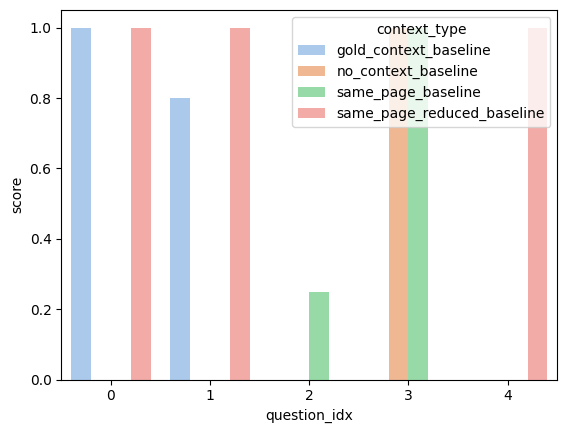

In [28]:
sns.barplot(
    data=df_scores,
    x="question_idx",
    y="score",
    hue="context_type",
    palette="pastel"
)